## 311 complaints changes after LinkNYC built

- Get LinkNYC kiosks information
    - Select 311 data time range
- Get 311 data
- Get ACS census data
    - Aggregate LinkNYC and 311 data into census block
- Overall changes analysis
    - WithKiosk and WithoutKiosk area
    - Visualization
    - Conclusion
- Detail changes analysis
    - Compare the changes after LinkNYC built
    - Visulization
    - Analyse the changes of each census block (try to classify them)

In [87]:
import numpy as np
import pandas as pd
import pylab as pl
import geopandas as gpd
import os
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
import datetime as dt
from matplotlib import gridspec
from fiona.crs import from_epsg
import shapely
# import choroplethNYC as cp
# import open311SNSL
from sodapy import Socrata

pd.set_option('display.max_columns', 500)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [8]:
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

### Get LinkNYC kiosks information

Get the linkNYC location data with lon and lat.

In [3]:
linkLocation = pd.read_csv("LinkNYC_Locations.csv")

In [4]:
linkLocation.head()

,CB Link ID,Borough,Community Board,Council District,Latitude,Longitude,Project Status,Smallest PPT,Street Address,Postcode,Link Site ID,Link Smoke Tested and Activated (A),Link Installation (A),Neighborhood Tabulation Area (NTA),Building Identification Number (BIN),Borough-Block-Lot (BBL),Census Tract (CT),Cross Street 1,Cross Street 2,IxN Corner,GF Permit Application ID,Location
0,LINK-019315,Bronx,205,14,40.850173,-73.910282,Live,146097,1 EAST 177 STREET,10453,bx-05-146097,07/13/2018,06/20/2018,Mount Hope,2008247,2028530001,2023301,JEROME AVENUE,WALTON AVENUE,SE,82392.0,"(40.850173, -73.91028173)"
1,LINK-008842,Manhattan,105,4,40.747114,-73.985245,Live,121611,1 EAST 32 STREET,10016,mn-05-121611,12/09/2016,10/01/2016,Midtown-Midtown South,1017006,1008620001,1007400,5 AVENUE,MADISON AVENUE,NE,NaN,"(40.74711441, -73.98524463)"
2,LINK-008843,Manhattan,105,4,40.747737,-73.984833,Live,121613,1 EAST 33 STREET,10016,mn-05-121613,03/23/2017,01/29/2017,Midtown-Midtown South,1017076,1008630006,1007400,5 AVENUE,MADISON AVENUE,NE,NaN,"(40.74773664, -73.98483344)"
3,LINK-000186,Manhattan,105,2,40.734148,-73.988740,Live,134620,1 IRVING PLACE,10003,mn-05-134620,07/19/2017,06/11/2017,Gramercy,1083247,1008707501,1005000,EAST 14 STREET,EAST 15 STREET,NW,NaN,"(40.73414765, -73.98873983)"
4,LINK-010750,Manhattan,102,3,40.730258,-74.006629,Live,123600,1 ST. LUKE'S PLACE,10014,mn-02-123600,01/26/2017,11/13/2016,West Village,1009773,1005830001,1006700,HUDSON STREET,7 AVENUE,NE,NaN,"(40.73025769, -74.00662855)"


In [161]:
linkLocation.shape

(1868, 22)

Select 311 data time range

In [5]:
def minmax(val_list):
    min_val = min(val_list)
    max_val = max(val_list)

    return (min_val, max_val)

In [6]:
linkLocation['active_date'] = pd.to_datetime(linkLocation['Link Smoke Tested and Activated (A)'])

In [7]:
minmax(linkLocation.active_date)

(Timestamp('2016-01-19 00:00:00'), Timestamp('2019-03-28 00:00:00'))

To wipe off the impact of season, we decide to use 2015.04 and 2015.05 311 data as the data before kiosk built, and use 2019.04 and 2019.05 311 data as the data after kiosk built.

### Get 311 data

In [9]:
def get311data(key, start_time, end_time):
    client = Socrata("data.cityofnewyork.us", key)
    results = client.get("fhrw-4uyv", where = "created_date BETWEEN " + start_time + " AND " +  end_time, limit = 1000000000)
    
    return(pd.DataFrame.from_records(results))

In [10]:
before = get311data('jjCh6OTqr3VrUwNTNl4bPGwAK',  "'2015-04-01T00:00:00'", "'2015-05-31T00:00:00'")

In [13]:
after = get311data('jjCh6OTqr3VrUwNTNl4bPGwAK',  "'2019-04-01T00:00:00'", "'2019-05-31T00:00:00'")

In [18]:
before = before[-before['location'].isna()]

In [20]:
before.head()

,address_type,agency,agency_name,bbl,borough,bridge_highway_direction,bridge_highway_name,bridge_highway_segment,city,closed_date,community_board,complaint_type,created_date,cross_street_1,cross_street_2,descriptor,due_date,facility_type,incident_address,incident_zip,intersection_street_1,intersection_street_2,landmark,latitude,location,location_type,longitude,open_data_channel_type,park_borough,park_facility_name,resolution_action_updated_date,resolution_description,road_ramp,status,street_name,taxi_company_borough,taxi_pick_up_location,unique_key,vehicle_type,x_coordinate_state_plane,y_coordinate_state_plane
1,ADDRESS,HPD,Department of Housing Preservation and Develop...,3060090024,BROOKLYN,NaN,NaN,NaN,BROOKLYN,2015-05-19T00:00:00.000,10 BROOKLYN,UNSANITARY CONDITION,2015-04-01T00:00:00.000,NaN,NaN,GARBAGE/RECYCLING STORAGE,NaN,N/A,552 82 STREET,11209,NaN,NaN,NaN,40.62357107616581,"{u'type': u'Point', u'coordinates': [-74.02352...",RESIDENTIAL BUILDING,-74.02352676703748,ONLINE,BROOKLYN,Unspecified,2015-05-19T00:00:00.000,The Department of Housing Preservation and Dev...,NaN,Closed,82 STREET,NaN,NaN,30298583,NaN,977719,166461
2,ADDRESS,HPD,Department of Housing Preservation and Develop...,2027240005,BRONX,NaN,NaN,NaN,BRONX,2015-04-03T00:00:00.000,02 BRONX,HEAT/HOT WATER,2015-04-01T00:00:00.000,NaN,NaN,APARTMENT ONLY,NaN,N/A,975 SIMPSON STREET,10459,NaN,NaN,NaN,40.821519494897075,"{u'type': u'Point', u'coordinates': [-73.89286...",RESIDENTIAL BUILDING,-73.89286979002962,PHONE,BRONX,Unspecified,2015-04-03T00:00:00.000,The Department of Housing Preservation and Dev...,NaN,Closed,SIMPSON STREET,NaN,NaN,30299044,NaN,1013901,238597
3,ADDRESS,HPD,Department of Housing Preservation and Develop...,4050437501,QUEENS,NaN,NaN,NaN,Flushing,2015-04-03T00:00:00.000,07 QUEENS,HEAT/HOT WATER,2015-04-01T00:00:00.000,NaN,NaN,ENTIRE BUILDING,NaN,N/A,136-05 SANFORD AVENUE,11355,NaN,NaN,NaN,40.75675108347201,"{u'type': u'Point', u'coordinates': [-73.82854...",RESIDENTIAL BUILDING,-73.82854025101055,ONLINE,QUEENS,Unspecified,2015-04-03T00:00:00.000,The complaint you filed is a duplicate of a co...,NaN,Closed,SANFORD AVENUE,NaN,NaN,30299153,NaN,1031752,215028
4,ADDRESS,DOHMH,Department of Health and Mental Hygiene,1004120011,MANHATTAN,NaN,NaN,NaN,NEW YORK,2015-04-01T00:00:00.000,03 MANHATTAN,Rodent,2015-04-01T00:00:00.000,STANTON STREET,EAST HOUSTON STREET,Rat Sighting,2015-05-01T01:21:51.000,N/A,192 ORCHARD STREET,10002,NaN,NaN,NaN,40.72217892201242,"{u'type': u'Point', u'coordinates': [-73.98813...",Other (Explain Below),-73.98813082421977,PHONE,MANHATTAN,Unspecified,2015-04-01T01:28:07.000,The Department of Health and Mental Hygiene wi...,NaN,Closed,ORCHARD STREET,NaN,NaN,30299598,NaN,987540,202386
5,ADDRESS,HPD,Department of Housing Preservation and Develop...,1021250053,MANHATTAN,NaN,NaN,NaN,NEW YORK,2015-04-12T00:00:00.000,12 MANHATTAN,UNSANITARY CONDITION,2015-04-01T00:00:00.000,NaN,NaN,PESTS,NaN,N/A,515 WEST 168 STREET,10032,NaN,NaN,NaN,40.84014503831177,"{u'type': u'Point', u'coordinates': [-73.93754...",RESIDENTIAL BUILDING,-73.93754560817383,PHONE,MANHATTAN,Unspecified,2015-04-12T00:00:00.000,The Department of Housing Preservation and Dev...,NaN,Closed,WEST 168 STREET,NaN,NaN,30299711,NaN,1001531,245371


In [22]:
before.shape

(331960, 41)

In [71]:
before = before[-before['location'].isna()].reset_index(drop = True)

In [72]:
after = after[-after['location'].isna()].reset_index(drop = True)

In [63]:
after.head()

,address_type,agency,agency_name,bbl,borough,bridge_highway_direction,bridge_highway_name,bridge_highway_segment,city,closed_date,community_board,complaint_type,created_date,cross_street_1,cross_street_2,descriptor,due_date,facility_type,incident_address,incident_zip,intersection_street_1,intersection_street_2,landmark,latitude,location,location_type,longitude,open_data_channel_type,park_borough,park_facility_name,resolution_action_updated_date,resolution_description,road_ramp,status,street_name,taxi_company_borough,taxi_pick_up_location,unique_key,vehicle_type,x_coordinate_state_plane,y_coordinate_state_plane
0,ADDRESS,DOHMH,Department of Health and Mental Hygiene,1005770019,MANHATTAN,NaN,NaN,NaN,NEW YORK,2019-04-19T00:00:00.000,02 MANHATTAN,Rodent,2019-04-01T00:00:00.000,5 AVENUE,AVENUE OF THE AMERICAS,Rat Sighting,2019-05-01T12:30:34.000,N/A,38 WEST 14 STREET,10011,NaN,NaN,NaN,40.73655645309282,"{u'type': u'Point', u'coordinates': [-73.99495...",Commercial Building,-73.99495180550892,PHONE,MANHATTAN,Unspecified,2019-04-19T00:00:00.000,The Department of Health and Mental Hygiene wi...,NaN,Closed,WEST 14 STREET,NaN,NaN,42111375,NaN,985649,207624
1,ADDRESS,DOHMH,Department of Health and Mental Hygiene,1020240028,MANHATTAN,NaN,NaN,NaN,NEW YORK,2019-04-18T00:00:00.000,10 MANHATTAN,Rodent,2019-04-01T00:00:00.000,7 AVENUE,8 AVENUE,Condition Attracting Rodents,2019-05-01T17:01:19.000,N/A,203 WEST 138 STREET,10030,NaN,NaN,NaN,40.81735829306793,"{u'type': u'Point', u'coordinates': [-73.94258...",3+ Family Mixed Use Building,-73.94258880254456,ONLINE,MANHATTAN,Unspecified,2019-04-15T00:00:00.000,The Department of Health and Mental Hygiene wi...,NaN,Closed,WEST 138 STREET,NaN,NaN,42110763,NaN,1000141,237068
2,LATLONG,DOHMH,Department of Health and Mental Hygiene,NaN,MANHATTAN,NaN,NaN,NaN,NEW YORK,2019-04-22T00:00:00.000,Unspecified MANHATTAN,Rodent,2019-04-01T00:00:00.000,NaN,NaN,Rat Sighting,2019-05-01T06:51:03.000,N/A,68 WEST 3 STREET,10012,NaN,NaN,NaN,40.72928295318702,"{u'type': u'Point', u'coordinates': [-73.99835...",Commercial Building,-73.99835834325633,MOBILE,MANHATTAN,Unspecified,2019-04-19T00:00:00.000,The Department of Health and Mental Hygiene wi...,NaN,Closed,WEST 3 STREET,NaN,NaN,42110095,NaN,984705,204974
3,LATLONG,DOHMH,Department of Health and Mental Hygiene,NaN,MANHATTAN,NaN,NaN,NaN,NEW YORK,2019-04-01T00:00:00.000,Unspecified MANHATTAN,Rodent,2019-04-01T00:00:00.000,NaN,NaN,Rat Sighting,2019-05-01T13:15:32.000,N/A,38 WEST 14 STREET,10011,NaN,NaN,NaN,40.736416502356555,"{u'type': u'Point', u'coordinates': [-73.99573...",Commercial Building,-73.99573484392096,MOBILE,MANHATTAN,Unspecified,2019-04-01T13:22:14.000,The Department of Health and Mental Hygiene wi...,NaN,Closed,WEST 14 STREET,NaN,NaN,42110092,NaN,985432,207573
4,ADDRESS,DOHMH,Department of Health and Mental Hygiene,2023570035,BRONX,NaN,NaN,NaN,BRONX,NaN,04 BRONX,Rodent,2019-04-01T00:00:00.000,EAST 150 STREET,MAJOR DEEGAN EXPWY ET 5 NB,Rat Sighting,2019-05-01T17:42:43.000,N/A,610 EXTERIOR STREET,10451,NaN,NaN,NaN,40.821743407535514,"{u'type': u'Point', u'coordinates': [-73.93086...",Commercial Building,-73.930860669189,PHONE,BRONX,Unspecified,2019-04-18T10:31:41.000,The Department of Health and Mental Hygiene wi...,NaN,Assigned,EXTERIOR STREET,NaN,NaN,42110041,NaN,1003386,238668


In [64]:
after.shape

(427917, 41)

In [76]:
before['latitude'] = before['latitude'].apply(lambda x: float(x)).tolist()
before['longitude'] = before['longitude'].apply(lambda x: float(x)).tolist()
after['latitude'] = after['latitude'].apply(lambda x: float(x)).tolist()
after['longitude'] = after['longitude'].apply(lambda x: float(x)).tolist()

In [77]:
(after.shape[0]+0.0)/before.shape[0]

1.2890619351729125

The overall 311 complaint counts of NYC is increase about 29%.

### Get ACS census data

In [26]:
censusBlock = gpd.GeoDataFrame.from_file("2010 Census Blocks/geo_export_dcac10a9-8f03-487a-87db-c20ab1b2d32b.shp")

In [27]:
censusBlock.head()

,bctcb2010,boro_code,boro_name,cb2010,ct2010,shape_area,shape_leng,geometry
0,50009001000,5,Staten Island,1000,000900,244589.603884,2508.948115,POLYGON ((-74.07920577013245 40.64343078374567...
1,50020011000,5,Staten Island,1000,002001,111006.286826,1345.886422,POLYGON ((-74.07061992438017 40.61085506705416...
2,50027001000,5,Staten Island,1000,002700,150406.766022,1703.381172,POLYGON ((-74.07524403910642 40.62600632452712...
3,50040001000,5,Staten Island,1000,004000,141296.561149,1511.173743,POLYGON ((-74.08708799689826 40.61116883123925...
4,50064001000,5,Staten Island,1000,006400,200784.983607,1978.243852,POLYGON ((-74.07643744511992 40.60100160655585...


In [29]:
sum(censusBlock.isna())

bctcb2010     0
boro_code     0
boro_name     0
cb2010        0
ct2010        0
shape_area    0
shape_leng    0
geometry      0
dtype: int64

In [30]:
censusBlock.shape

(38796, 8)

Aggregate LinkNYC and 311 data into census block.

In [31]:
linkLocation['lonlat'] = list(zip(linkLocation.Longitude,linkLocation.Latitude))
linkLocation['geometry'] = linkLocation[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

linkLocation = gpd.GeoDataFrame(linkLocation)
linkLocation.crs = from_epsg(4326)

linkLocation_ft = linkLocation.to_crs(epsg=2263)
censusBlock_ft = censusBlock.to_crs(epsg=2263)

In [47]:
kioskCountBlock = gpd.sjoin(censusBlock_ft, linkLocation_ft).groupby('bctcb2010').size().to_frame().rename(columns = {0: 'linknycCount'})
kioskCountBlock.reset_index(inplace = True)

In [54]:
kioskCountBlock = censusBlock_ft.merge(kioskCountBlock, how = 'outer')[['bctcb2010', 'linknycCount']].fillna(0)

In [57]:
kioskCountBlock['linknycCount'] = kioskCountBlock['linknycCount'].apply(lambda x: int(x)).tolist()

In [79]:
before['lonlat'] = list(zip(before.longitude,before.latitude))
before['geometry'] = before[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

before = gpd.GeoDataFrame(before)
before.crs = from_epsg(4326)

before_ft = before.to_crs(epsg=2263)
#censusBlock_ft = censusBlock.to_crs(epsg=2263)

In [80]:
after['lonlat'] = list(zip(after.longitude,after.latitude))
after['geometry'] = after[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

after = gpd.GeoDataFrame(after)
after.crs = from_epsg(4326)

after_ft = after.to_crs(epsg=2263)

In [81]:
before311CountBlock = gpd.sjoin(censusBlock_ft, before_ft).groupby('bctcb2010').size().to_frame().rename(columns = {0: 'beforeCount'})
before311CountBlock.reset_index(inplace = True)

In [82]:
after311CountBlock = gpd.sjoin(censusBlock_ft, after_ft).groupby('bctcb2010').size().to_frame().rename(columns = {0: 'afterCount'})
after311CountBlock.reset_index(inplace = True)

In [83]:
before311CountBlock = censusBlock_ft.merge(before311CountBlock, how = 'outer')[['bctcb2010', 'beforeCount']].fillna(0)
after311CountBlock = censusBlock_ft.merge(after311CountBlock, how = 'outer')[['bctcb2010', 'afterCount']].fillna(0)

In [84]:
before311CountBlock['beforeCount'] = before311CountBlock['beforeCount'].apply(lambda x: int(x)).tolist()
after311CountBlock['afterCount'] = after311CountBlock['afterCount'].apply(lambda x: int(x)).tolist()

In [88]:
before311CountBlock.head()

,bctcb2010,beforeCount
0,50009001000,8
1,50020011000,2
2,50027001000,48
3,50040001000,2
4,50064001000,2


In [89]:
after311CountBlock.head()

,bctcb2010,afterCount
0,50009001000,13
1,50020011000,0
2,50027001000,42
3,50040001000,3
4,50064001000,3


### Overall changes analysis
- WithKiosk and WithoutKiosk area
- Visualization
- Conclusion

Use after data for this analysis.

In [103]:
kioskCountBlock['Label'] = 'With'
kioskCountBlock['Label'][kioskCountBlock['linknycCount'] == 0] = 'Without'

C:\Users\sherr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [105]:
kioskCountBlock.head()

,bctcb2010,linknycCount,Label
0,50009001000,0,Without
1,50020011000,0,Without
2,50027001000,0,Without
3,50040001000,0,Without
4,50064001000,0,Without


In [106]:
linkWithAfterBlock = kioskCountBlock.merge(after311CountBlock)

In [107]:
linkWithAfterBlock.head()

,bctcb2010,linknycCount,Label,afterCount
0,50009001000,0,Without,13
1,50020011000,0,Without,0
2,50027001000,0,Without,42
3,50040001000,0,Without,3
4,50064001000,0,Without,3


In [109]:
linkWithAfterBlockShape = censusBlock.merge(linkWithAfterBlock)

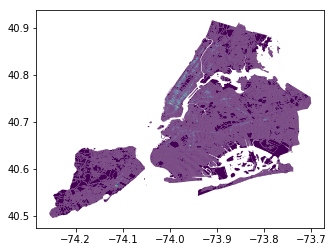

In [111]:
linkWithAfterBlockShape.plot('linknycCount')

Get the NYC zipcode shapefile.

In [314]:
shapefileNYC = gpd.GeoDataFrame.from_file("ZIP_CODE_SHAPE/ZIP_CODE_040114.shp")

In [315]:
shapefileNYC.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [316]:
sum(shapefileNYC.isna())

ZIPCODE       0
BLDGZIP       0
PO_NAME       0
POPULATION    0
AREA          0
STATE         0
COUNTY        0
ST_FIPS       0
CTY_FIPS      0
URL           0
SHAPE_AREA    0
SHAPE_LEN     0
geometry      0
dtype: int64

In [317]:
shapefileNYC.shape

(263, 13)

In [318]:
len(set(shapefileNYC['ZIPCODE']))

248

merge LinkNYC location with nyc zipcode shapefile by lon and lat.

In [319]:
linkLocation['lonlat'] = list(zip(linkLocation.Longitude,linkLocation.Latitude))
linkLocation['geometry'] = linkLocation[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

linkLocation = gpd.GeoDataFrame(linkLocation)
linkLocation.crs = from_epsg(4326)

linkLocation_ft = linkLocation.to_crs(epsg=2263)
shapefileNYC_ft = shapefileNYC.to_crs(epsg=2263)

In [320]:
zipcodeCounts = gpd.sjoin(shapefileNYC_ft, linkLocation_ft).groupby('ZIPCODE').size().to_frame().rename(columns = {0: 'linknycCount'})
zipcodeCounts.reset_index(inplace = True)

In [321]:
zipcodeCounts.head()

,ZIPCODE,linknycCount
0,10001,51
1,10002,12
2,10003,71
3,10004,2
4,10005,2


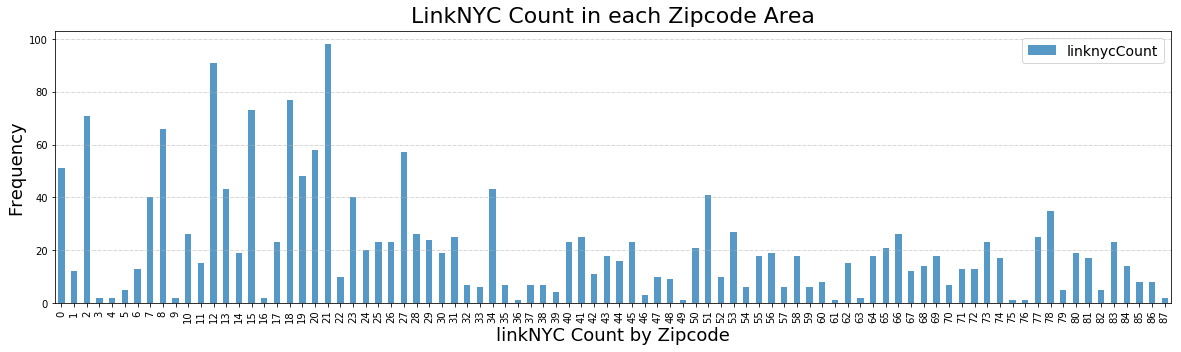

In [322]:
fig = pl.figure(figsize = (20,5))
ax = fig.add_subplot(111)

zipcodeCounts.plot.bar(alpha=0.75, ax=ax)

ax.set_title("LinkNYC Count in each Zipcode Area", fontsize=22, y=1.01)
ax.set_xlabel("linkNYC Count by Zipcode", fontsize=18)
ax.set_ylabel("Frequency", fontsize=18)


pl.grid(linewidth=0.5, axis='y', linestyle='-.')
pl.legend(fontsize=14)
pl.show()

This is the LinkNYC Count in each zipcode area. We could find that there some zipcode area has very low number of LinkNYC kiosks.

In [323]:
lowLinkArea = zipcodeCounts[zipcodeCounts['linknycCount']<5]
highLinkArea = zipcodeCounts[zipcodeCounts['linknycCount']>40]

In [324]:
lowLinkArea['linknycCount'] = 1
highLinkArea['linknycCount'] = 1

C:\Users\sherr\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\sherr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [325]:
lowLinkArea.shape, highLinkArea.shape

((13, 2), (13, 2))

show the lowLink and high link area in the map

In [326]:
shapefileNYC = shapefileNYC.merge(zipcodeCounts, left_on = 'ZIPCODE', right_on = 'ZIPCODE', how = 'left')

In [327]:
lowLinkArea.reset_index(drop = True, inplace = True)

In [328]:
highLinkArea.reset_index(drop = True, inplace = True)

In [329]:
shapefileNYC = shapefileNYC.merge(lowLinkArea, left_on = 'ZIPCODE', right_on = 'ZIPCODE', how = 'left')
shapefileNYC = shapefileNYC.merge(highLinkArea, left_on = 'ZIPCODE', right_on = 'ZIPCODE', how = 'left')

shapefileNYC = shapefileNYC.rename(columns = {'linknycCount_y': 'lowCount', 'linknycCount': 'highCount', 'linknycCount_x': 'linknycCount'})

In [330]:
shapefileNYC.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,linknycCount,lowCount,highCount
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",NaN,NaN,NaN
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",2.0,1.0,NaN
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1...",NaN,NaN,NaN
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,...",14.0,NaN,NaN
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,...",NaN,NaN,NaN


In [331]:
shapefileNYC['linknycCount'] = shapefileNYC['linknycCount'].fillna(0)
shapefileNYC['lowCount'] = shapefileNYC['lowCount'].fillna(0)
shapefileNYC['highCount'] = shapefileNYC['highCount'].fillna(0)

In [332]:
shapefileNYC.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,linknycCount,lowCount,highCount
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",0.0,0.0,0.0
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",2.0,1.0,0.0
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1...",0.0,0.0,0.0
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,...",14.0,0.0,0.0
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,...",0.0,0.0,0.0


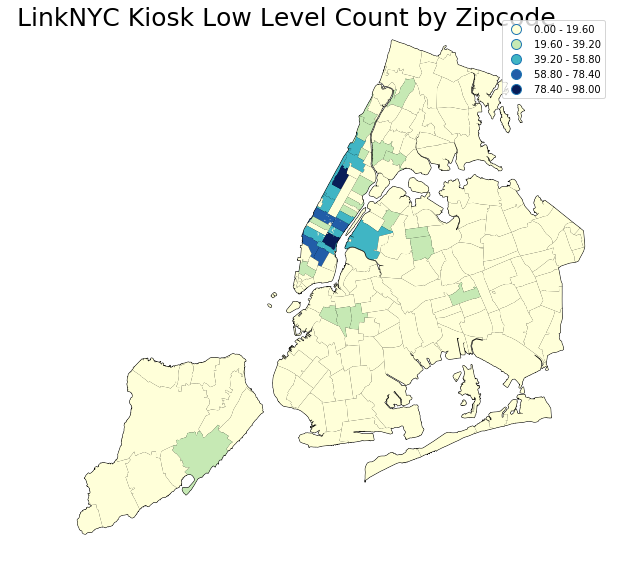

In [357]:
fig = pl.figure(figsize=(10,10))
ax = fig.add_subplot(111)
shapefileNYC.plot(facecolor="k", edgecolor="k",ax=ax)
shapefileNYC.plot(ax=ax, column="linknycCount", cmap='YlGnBu', scheme='Equal_Interval', label='linknycCount',legend = True)
plt.title('LinkNYC Kiosk Low Level Count by Zipcode', size=25, y=.97, x=0.42)
ax.axis('off')
plt.show()

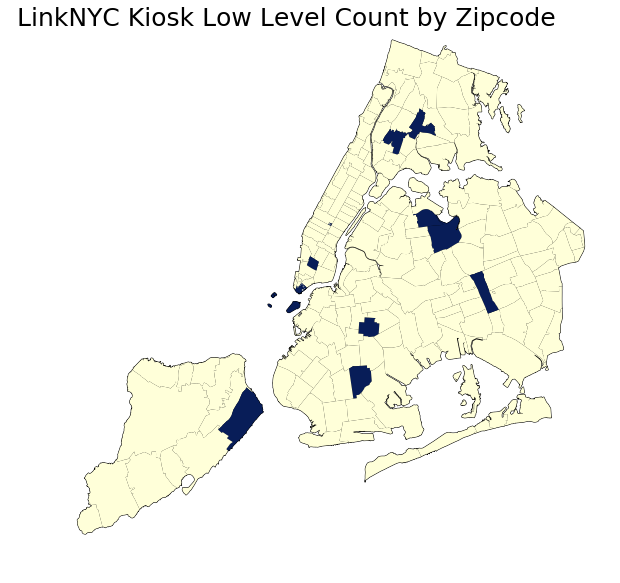

In [355]:
fig = pl.figure(figsize=(10,10))
ax = fig.add_subplot(111)
shapefileNYC.plot(facecolor="k", edgecolor="k",ax=ax)
shapefileNYC.plot(ax=ax, column="lowCount", cmap='YlGnBu',  label='lowCount')
plt.title('LinkNYC Kiosk Low Level Count by Zipcode', size=25, y=.97, x=0.42)
ax.axis('off')
plt.show()

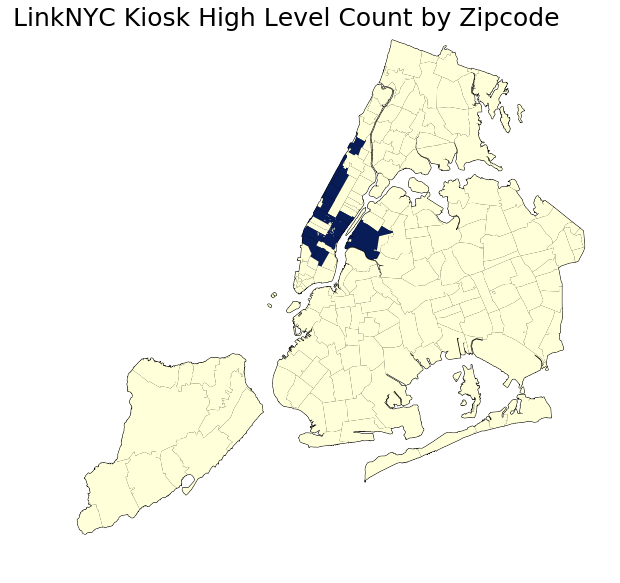

In [356]:
fig = pl.figure(figsize=(10,10))
ax = fig.add_subplot(111)
shapefileNYC.plot(facecolor="k", edgecolor="k",ax=ax)
shapefileNYC.plot(ax=ax, column="highCount", cmap='YlGnBu', label='highCount')
plt.title('LinkNYC Kiosk High Level Count by Zipcode', size=25, y=.97, x=0.42)
ax.axis('off')
plt.show()

explore the whole picture 311 type changes before and after LinkNYC built in each borough

In [360]:
linkLocation['active_date'] = pd.to_datetime(linkLocation['Link Smoke Tested and Activated (A)'])

In [361]:
linkLocation.head()

,CB Link ID,Borough,Community Board,Council District,Latitude,Longitude,Project Status,Smallest PPT,Street Address,Postcode,Link Site ID,Link Smoke Tested and Activated (A),Link Installation (A),Neighborhood Tabulation Area (NTA),Building Identification Number (BIN),Borough-Block-Lot (BBL),Census Tract (CT),Cross Street 1,Cross Street 2,IxN Corner,GF Permit Application ID,Location,lonlat,geometry,active_date
0,LINK-019315,Bronx,205,14,40.850173,-73.910282,Live,146097,1 EAST 177 STREET,10453,bx-05-146097,07/13/2018,06/20/2018,Mount Hope,2008247,2028530001,2023301,JEROME AVENUE,WALTON AVENUE,SE,82392.0,"(40.850173, -73.91028173)","(-73.910282, 40.850173)",POINT (-73.910282 40.850173),2018-07-13
1,LINK-008842,Manhattan,105,4,40.747114,-73.985245,Live,121611,1 EAST 32 STREET,10016,mn-05-121611,12/09/2016,10/01/2016,Midtown-Midtown South,1017006,1008620001,1007400,5 AVENUE,MADISON AVENUE,NE,NaN,"(40.74711441, -73.98524463)","(-73.985245, 40.747114)",POINT (-73.98524499999999 40.747114),2016-12-09
2,LINK-008843,Manhattan,105,4,40.747737,-73.984833,Live,121613,1 EAST 33 STREET,10016,mn-05-121613,03/23/2017,01/29/2017,Midtown-Midtown South,1017076,1008630006,1007400,5 AVENUE,MADISON AVENUE,NE,NaN,"(40.74773664, -73.98483344)","(-73.984833, 40.747737)",POINT (-73.984833 40.747737),2017-03-23
3,LINK-000186,Manhattan,105,2,40.734148,-73.988740,Live,134620,1 IRVING PLACE,10003,mn-05-134620,07/19/2017,06/11/2017,Gramercy,1083247,1008707501,1005000,EAST 14 STREET,EAST 15 STREET,NW,NaN,"(40.73414765, -73.98873983)","(-73.98874, 40.734148)",POINT (-73.98874000000001 40.734148),2017-07-19
4,LINK-010750,Manhattan,102,3,40.730258,-74.006629,Live,123600,1 ST. LUKE'S PLACE,10014,mn-02-123600,01/26/2017,11/13/2016,West Village,1009773,1005830001,1006700,HUDSON STREET,7 AVENUE,NE,NaN,"(40.73025769, -74.00662855)","(-74.006629, 40.730258)",POINT (-74.006629 40.730258),2017-01-26


In [362]:
linkLocation.shape

(1868, 25)

In [363]:
linkLocation = linkLocation[pd.notnull(linkLocation['active_date'])]

In [364]:
linkLocation.shape

(1815, 25)

In [365]:
set(linkLocation["Borough"])

{'Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'}

In [369]:
brooklyn_kiosk = linkLocation[linkLocation["Borough"]=="Brooklyn"]
bronx_kiosk = linkLocation[linkLocation["Borough"]=="Bronx"]
manhattan_kiosk = linkLocation[linkLocation["Borough"]=="Manhattan"]
queens_kiosk = linkLocation[linkLocation["Borough"]=="Queens"]
staten_kiosk = linkLocation[linkLocation["Borough"]=="Staten Island"]

In [370]:
def minmax(val_list):
    min_val = min(val_list)
    max_val = max(val_list)

    return (min_val, max_val)

In [371]:
print(minmax(brooklyn_kiosk.active_date))
print(minmax(bronx_kiosk.active_date))
print(minmax(manhattan_kiosk.active_date))
print(minmax(queens_kiosk.active_date))
print(minmax(staten_kiosk.active_date))

(Timestamp('2016-11-08 00:00:00'), Timestamp('2019-03-20 00:00:00'))
(Timestamp('2016-05-25 00:00:00'), Timestamp('2018-08-24 00:00:00'))
(Timestamp('2016-01-19 00:00:00'), Timestamp('2019-03-28 00:00:00'))
(Timestamp('2016-07-29 00:00:00'), Timestamp('2019-02-28 00:00:00'))
(Timestamp('2016-12-09 00:00:00'), Timestamp('2018-07-19 00:00:00'))


In [31]:
url = "https://data.cityofnewyork.us/resource/fhrw-4uyv.json?$where=created_date%20BETWEEN%20%272015-11-01T00:00:00%27%20AND%20%272015-12-31T00:00:00%27"
before = pd.read_json(url)

url = "https://data.cityofnewyork.us/resource/fhrw-4uyv.json?$where=created_date%20BETWEEN%20%272018-11-01T00:00:00%27%20AND%20%272018-12-31T00:00:00%27"
after = pd.read_json(url)

In [32]:
boroList = ['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND', 'Unspecified']

BRONX


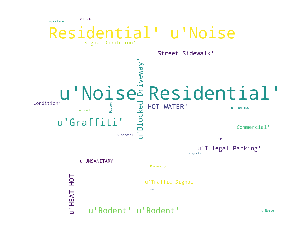

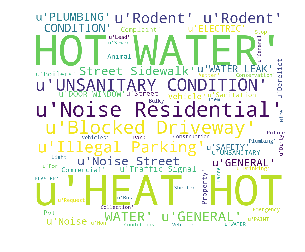

BROOKLYN


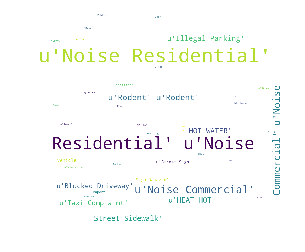

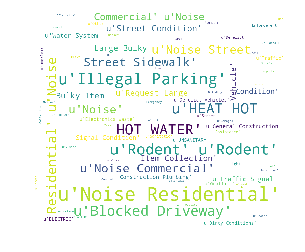

MANHATTAN


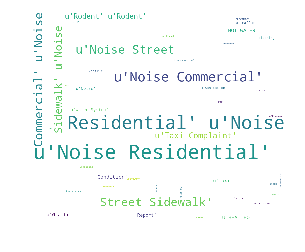

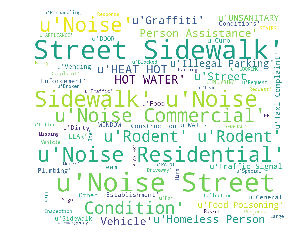

QUEENS


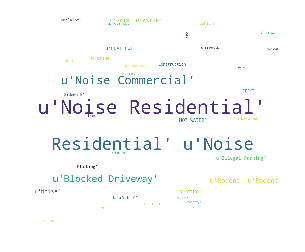

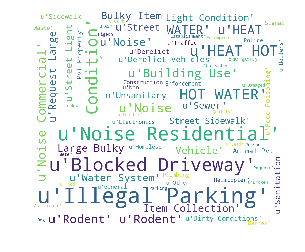

STATEN ISLAND


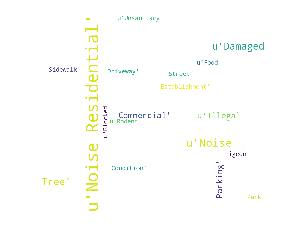

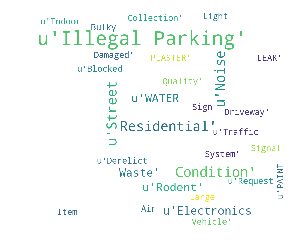

Unspecified


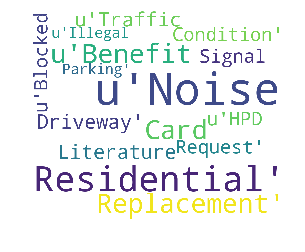

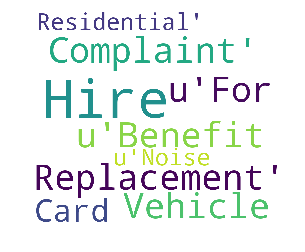

In [33]:
from wordcloud import WordCloud

#from .query_integral_image import query_integral_image

for item in boroList:
    boro_before = before[before["borough"]==item]
    boro_after = after[after["borough"]==item]

    complaint_before = boro_before['complaint_type'].values
    complaint_after = boro_after['complaint_type'].values
    
    complaint_before = str(list(complaint_before))
    complaint_after = str(list(complaint_after))
    
    print(item)
    
    wordcloud = WordCloud(background_color="white",width=1000, height=860, margin=2).generate(complaint_before)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    wordcloud.to_file(item + 'before.png')
    
    wordcloud = WordCloud(background_color="white",width=1000, height=860, margin=2).generate(complaint_after)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    wordcloud.to_file(item + 'after.png')

Looking the 311 complaint number and type different of high kiosks area and low kiosks area.

Get 311 data of 

In [243]:
monthlyUsage = pd.read_csv("July 2018 Monthly LinkNYC Data - Per-AP.csv")

In [3]:
monthlyUsage.head()

,AP Device Name,Boro,CB,PPT ID,Street Address,Latitude,Longitude,SSID(s),Uptime %,Number of Unique Clients,Number of Sessions,Minutes Used,MB Transferred (upload),MB Transferred (download),MB Transferred (total),Daily Avg - Number of Unique Clients,Daily Avg - Number of Sessions,Daily Avg - Minutes Used,Daily Avg - MB Transferred (upload),Daily Avg - MB Transferred (download),Daily Avg - MB Transferred (total)
0,bk-01-108703,bk,1,108703,213 UNION AVENUE,40.706822,-73.950529,"LinkNYC Free Wi-Fi, LinkNYC Private, SONYC IOT",100.00%,"11,593","36,797","102,960","17,046","142,473","159,519",374,"1,187","3,321",550,"4,596","5,146"
1,bk-01-108949,bk,1,108949,709 BROADWAY,40.701419,-73.942908,"LinkNYC Free Wi-Fi, LinkNYC Private, SONYC IOT",99.87%,"25,219","75,194","234,063","41,436","327,003","368,439",814,"2,426","7,550","1,337","10,548","11,885"
2,bk-01-108952,bk,1,108952,511 BROADWAY,40.705371,-73.949963,"LinkNYC Free Wi-Fi, LinkNYC Private, SONYC IOT",100.00%,"23,497","56,722","138,142","27,941","194,260","222,201",758,"1,830","4,456",901,"6,266","7,168"
3,bk-01-109091,bk,1,109091,24 GRAHAM AVENUE,40.701542,-73.942169,"LinkNYC Free Wi-Fi, LinkNYC Private, SONYC IOT",99.87%,"9,336","31,424","179,954","18,587","246,474","265,060",301,"1,014","5,805",600,"7,951","8,550"
4,bk-01-109252,bk,1,109252,395 BROADWAY,40.707208,-73.954195,"LinkNYC Free Wi-Fi, LinkNYC Private, SONYC IOT",100.00%,"35,990","107,471","298,471","52,864","359,326","412,189","1,894","5,656","15,709","2,782","18,912","21,694"


In [58]:
policyData = pd.read_csv("PolicyMap Data 2019-04-11 1511UTC.csv")

In [59]:
policyData.head()

,Zip Code Tabulation Area,FIPS Code,Formatted FIPS,Estimated percent of households with a subscription to broadband
0,10314,10314.0,"=""10314""",78.71
1,11234,11234.0,"=""11234""",75.72
2,10312,10312.0,"=""10312""",81.77
3,10306,10306.0,"=""10306""",75.95
4,11430,11430.0,"=""11430""",NaN


In [60]:
policyData.shape

(217, 4)

In [61]:
sum(policyData.isna())

Zip Code Tabulation Area                                             0
FIPS Code                                                            6
Formatted FIPS                                                       6
Estimated percent of households with a subscription to broadband    38
dtype: int64

In [62]:
policyData.dropna(inplace=True)

In [63]:
policyData.shape

(179, 4)

In [88]:
len(set(policyData['Zip Code Tabulation Area']))

179

In [128]:
shapefileNYC = shapefileNYC.merge(policyData, right_on = "Zip Code Tabulation Area", left_on = "ZIPCODE", how = 'right')

In [129]:
shapefileNYC.shape

(191, 17)

In [130]:
#shapeNYCwithPolicy.drop_duplicates(subset=['A', 'C'], keep=False)

In [131]:
sum(shapefileNYC.isna())

ZIPCODE                                                             0
BLDGZIP                                                             0
PO_NAME                                                             0
POPULATION                                                          0
AREA                                                                0
STATE                                                               0
COUNTY                                                              0
ST_FIPS                                                             0
CTY_FIPS                                                            0
URL                                                                 0
SHAPE_AREA                                                          0
SHAPE_LEN                                                           0
geometry                                                            0
Zip Code Tabulation Area                                            0
FIPS Code           

In [132]:
len(set(shapefileNYC['ZIPCODE']))

179

In [133]:
shapefileNYC.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,Zip Code Tabulation Area,FIPS Code,Formatted FIPS,Estimated percent of households with a subscription to broadband
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",11436,11436.0,"=""11436""",65.37
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",11213,11213.0,"=""11213""",62.95
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1...",11212,11212.0,"=""11212""",58.12
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,...",11225,11225.0,"=""11225""",67.98
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,...",11218,11218.0,"=""11218""",70.67


In [134]:
shapefileNYC.drop(['Zip Code Tabulation Area', 'FIPS Code', 'Formatted FIPS'], axis = 1, inplace = True)

In [135]:
shapefileNYC.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,Estimated percent of households with a subscription to broadband
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",65.37
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",62.95
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1...",58.12
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,...",67.98
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,...",70.67


In [136]:
shapefileNYC_ft = shapefileNYC.to_crs(epsg=2263)

In [137]:
monthlyUsage['lonlat'] = list(zip(monthlyUsage.Longitude,monthlyUsage.Latitude))
monthlyUsage['geometry'] = monthlyUsage[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [138]:
monthlyUsage = gpd.GeoDataFrame(monthlyUsage)

In [139]:
monthlyUsage.crs = from_epsg(4326)

In [140]:
monthlyUsage_ft = monthlyUsage.to_crs(epsg=2263)

In [141]:
monthlyUsageZipcode = gpd.sjoin(shapefileNYC_ft, monthlyUsage_ft)

In [142]:
monthlyUsageZipcode.reset_index(drop = True, inplace = True)

In [143]:
monthlyUsageZipcode.head(1)

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,Estimated percent of households with a subscription to broadband,index_right,AP Device Name,Boro,CB,PPT ID,Street Address,Latitude,Longitude,SSID(s),Uptime %,Number of Unique Clients,Number of Sessions,Minutes Used,MB Transferred (upload),MB Transferred (download),MB Transferred (total),Daily Avg - Number of Unique Clients,Daily Avg - Number of Sessions,Daily Avg - Minutes Used,Daily Avg - MB Transferred (upload),Daily Avg - MB Transferred (download),Daily Avg - MB Transferred (total),lonlat
0,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.71296406 186926.4395293033, ...",62.95,94,bk-03-145749,bk,3,145749,1628 FULTON STREET,40.679561,-73.9355,"LinkNYC Free Wi-Fi, LinkNYC Private, SONYC IOT",100.00%,"15,182","42,873","111,437","22,290","186,040","208,330",490,"1,383","3,595",719,"6,001","6,720","(-73.93549973, 40.67956068)"


In [144]:
monthlyUsageZipcode.drop(['BLDGZIP', 'CTY_FIPS', 'ST_FIPS', 'SSID(s)', 'STATE', 'COUNTY', 'URL', 'SHAPE_AREA', 'SHAPE_LEN', 'index_right', 'Boro', ], axis = 1, inplace = True)

In [145]:
monthlyUsageZipcode.head()

,ZIPCODE,PO_NAME,POPULATION,AREA,geometry,Estimated percent of households with a subscription to broadband,AP Device Name,CB,PPT ID,Street Address,Latitude,Longitude,Uptime %,Number of Unique Clients,Number of Sessions,Minutes Used,MB Transferred (upload),MB Transferred (download),MB Transferred (total),Daily Avg - Number of Unique Clients,Daily Avg - Number of Sessions,Daily Avg - Minutes Used,Daily Avg - MB Transferred (upload),Daily Avg - MB Transferred (download),Daily Avg - MB Transferred (total),lonlat
0,11213,Brooklyn,62426.0,2.963100e+07,"POLYGON ((1001613.71296406 186926.4395293033, ...",62.95,bk-03-145749,3,145749,1628 FULTON STREET,40.679561,-73.935500,100.00%,"15,182","42,873","111,437","22,290","186,040","208,330",490,"1,383","3,595",719,"6,001","6,720","(-73.93549973, 40.67956068)"
1,11213,Brooklyn,62426.0,2.963100e+07,"POLYGON ((1001613.71296406 186926.4395293033, ...",62.95,bk-03-145759,3,145759,1546 FULTON STREET,40.679752,-73.939101,100.00%,"13,998","54,966","300,095","41,523","297,594","339,118",452,"1,773","9,680","1,339","9,600","10,939","(-73.93910101, 40.67975193)"
2,11225,Brooklyn,56527.0,2.369863e+07,"POLYGON ((995908.3654508907 183617.6128136422,...",67.98,bk-09-127022,9,127022,1208 NOSTRAND AVENUE,40.657740,-73.950407,100.00%,"12,421","58,252","303,969","38,068","424,068","462,136",401,"1,879","9,805","1,228","13,680","14,908","(-73.95040697, 40.65773965)"
3,11225,Brooklyn,56527.0,2.369863e+07,"POLYGON ((995908.3654508907 183617.6128136422,...",67.98,bk-09-127021,9,127021,1106 NOSTRAND AVENUE,40.660732,-73.950727,99.87%,"10,060","35,284","140,386","22,479","181,024","203,503",325,"1,138","4,529",725,"5,839","6,565","(-73.95072664, 40.6607318)"
4,11225,Brooklyn,56527.0,2.369863e+07,"POLYGON ((995908.3654508907 183617.6128136422,...",67.98,bk-09-145844,9,145844,317 LEFFERTS AVENUE,40.662438,-73.950605,99.87%,"9,418","37,671","128,707","14,693","175,966","190,658",304,"1,215","4,152",474,"5,676","6,150","(-73.950605, 40.662438)"


In [146]:
columnName = ['Number of Unique Clients', 'Number of Sessions', 'Minutes Used', 'MB Transferred (upload)', 'MB Transferred (download)', 
              'MB Transferred (total)', 'Daily Avg - Number of Unique Clients', 'Daily Avg - Number of Sessions', 'Daily Avg - Minutes Used', 
              'Daily Avg - MB Transferred (upload)', 'Daily Avg - MB Transferred (download)', 'Daily Avg - MB Transferred (total)']

In [147]:
for name in columnName:
    monthlyUsageZipcode[name] = monthlyUsageZipcode[name].apply(lambda x: x.replace(',', ''))
    monthlyUsageZipcode[name] = monthlyUsageZipcode[name].astype('float') 

In [148]:
monthlyUsageZipcodeMean = monthlyUsageZipcode.groupby('ZIPCODE').mean()[columnName].reset_index()

In [149]:
shapefileUsage = shapefileNYC.merge(monthlyUsageZipcodeMean)

In [150]:
shapefileUsage.head(1)

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,Estimated percent of households with a subscription to broadband,Number of Unique Clients,Number of Sessions,Minutes Used,MB Transferred (upload),MB Transferred (download),MB Transferred (total),Daily Avg - Number of Unique Clients,Daily Avg - Number of Sessions,Daily Avg - Minutes Used,Daily Avg - MB Transferred (upload),Daily Avg - MB Transferred (download),Daily Avg - MB Transferred (total)
0,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",62.95,14590.0,48919.5,205766.0,31906.5,241817.0,273724.0,471.0,1578.0,6637.5,1029.0,7800.5,8829.5


In [151]:
shapefileUsage.corr()['Estimated percent of households with a subscription to broadband']

POPULATION                                                         -0.517715
AREA                                                               -0.260298
SHAPE_AREA                                                               NaN
SHAPE_LEN                                                                NaN
Estimated percent of households with a subscription to broadband    1.000000
Number of Unique Clients                                            0.298728
Number of Sessions                                                  0.234978
Minutes Used                                                        0.042819
MB Transferred (upload)                                             0.153618
MB Transferred (download)                                          -0.147193
MB Transferred (total)                                             -0.107310
Daily Avg - Number of Unique Clients                                0.091086
Daily Avg - Number of Sessions                                     -0.001463

In [152]:
client = Socrata("data.cityofnewyork.us",
                 "jjCh6OTqr3VrUwNTNl4bPGwAK")

results = client.get("fhrw-4uyv", where = "created_date BETWEEN  '2018-07-01T00:00:00' AND '2018-07-31T00:00:00'", limit = 300000)

data311 = pd.DataFrame.from_records(results)

In [153]:
data311.shape

(229987, 41)

In [154]:
data311.head()

,address_type,agency,agency_name,bbl,borough,bridge_highway_direction,bridge_highway_name,bridge_highway_segment,city,closed_date,community_board,complaint_type,created_date,cross_street_1,cross_street_2,descriptor,due_date,facility_type,incident_address,incident_zip,intersection_street_1,intersection_street_2,landmark,latitude,location,location_type,longitude,open_data_channel_type,park_borough,park_facility_name,resolution_action_updated_date,resolution_description,road_ramp,status,street_name,taxi_company_borough,taxi_pick_up_location,unique_key,vehicle_type,x_coordinate_state_plane,y_coordinate_state_plane
0,ADDRESS,DOHMH,Department of Health and Mental Hygiene,1009090034,MANHATTAN,NaN,NaN,NaN,NEW YORK,2018-07-05T14:13:30.000,06 MANHATTAN,Rodent,2018-07-01T00:00:00.000,EAST 28 STREET,EAST 29 STREET,Mouse Sighting,2018-07-31T01:40:36.000,N/A,519 2 AVENUE,10016,NaN,NaN,NaN,40.74155544671306,"{u'type': u'Point', u'coordinates': [-73.97824...",3+ Family Apt. Building,-73.97824313903494,ONLINE,MANHATTAN,Unspecified,2018-07-05T14:13:30.000,The Department of Health and Mental Hygiene wi...,NaN,Closed,2 AVENUE,NaN,NaN,39612067,NaN,990279,209446
1,ADDRESS,DOHMH,Department of Health and Mental Hygiene,3076760054,BROOKLYN,NaN,NaN,NaN,BROOKLYN,NaN,14 BROOKLYN,Rodent,2018-07-01T00:00:00.000,BAY AVENUE,AVENUE O,Rat Sighting,2018-07-31T01:47:58.000,N/A,1523 EAST 22 STREET,11210,NaN,NaN,NaN,40.6145908510569,"{u'type': u'Point', u'coordinates': [-73.95227...",1-2 Family Dwelling,-73.95227564865068,PHONE,BROOKLYN,Unspecified,2018-07-01T01:51:48.000,The Department of Health and Mental Hygiene wi...,NaN,Assigned,EAST 22 STREET,NaN,NaN,39612795,NaN,997500,163192
2,ADDRESS,DSNY,Department of Sanitation,1004470039,MANHATTAN,NaN,NaN,NaN,NEW YORK,2018-07-03T00:00:00.000,03 MANHATTAN,Request Large Bulky Item Collection,2018-07-01T00:00:00.000,2 AVENUE,1 AVENUE,Request Large Bulky Item Collection,NaN,N/A,339 EAST 5 STREET,10003,NaN,NaN,NaN,40.726364661118076,"{u'type': u'Point', u'coordinates': [-73.98797...",Sidewalk,-73.98797493992541,PHONE,MANHATTAN,Unspecified,2018-07-03T00:00:00.000,NaN,NaN,Closed,EAST 5 STREET,NaN,NaN,39613462,NaN,987583,203911
3,ADDRESS,DOHMH,Department of Health and Mental Hygiene,3082720026,BROOKLYN,NaN,NaN,NaN,BROOKLYN,2018-07-10T00:00:00.000,18 BROOKLYN,Standing Water,2018-07-01T00:00:00.000,EAST 105 STREET,EAST 108 STREET,Swimming Pool - Unmaintained,2018-07-31T23:16:15.000,N/A,10554 FLATLANDS 6 STREET,11236,NaN,NaN,NaN,40.64226198000999,"{u'type': u'Point', u'coordinates': [-73.88685...",1-2 Family Dwelling,-73.88685536466816,ONLINE,BROOKLYN,Unspecified,2018-07-09T00:00:00.000,The Department of Health and Mental Hygiene wi...,NaN,Closed,FLATLANDS 6 STREET,NaN,NaN,39613819,NaN,1015650,173290
4,ADDRESS,DOHMH,Department of Health and Mental Hygiene,5003740146,STATEN ISLAND,NaN,NaN,NaN,STATEN ISLAND,2018-07-01T00:00:00.000,01 STATEN ISLAND,Rodent,2018-07-01T00:00:00.000,ELMIRA AVENUE,CONSTANT AVENUE,Condition Attracting Rodents,2018-07-31T21:36:54.000,N/A,41 WESTCOTT BOULEVARD,10314,NaN,NaN,NaN,40.619533241068716,"{u'type': u'Point', u'coordinates': [-74.12801...",1-2 Family Dwelling,-74.12801163017133,ONLINE,STATEN ISLAND,Unspecified,2018-07-01T21:39:37.000,The Department of Health and Mental Hygiene wi...,NaN,Closed,WESTCOTT BOULEVARD,NaN,NaN,39614027,NaN,948712,165015


In [34]:
#data311[data311['address_type']=='INTERSECTION']

In [37]:
#data311.dropna(inplace = True)

In [475]:
data311['lonlat'] = list(zip(data311.longitude.astype(float),data311.latitude.astype(float)))
data311['geometry'] = data311[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [476]:
data311 = gpd.GeoDataFrame(data311)
data311.crs = from_epsg(4326)
data311_ft = data311.to_crs(epsg=2263)

In [477]:
monthlyUsage311 = gpd.sjoin(shapefileNYC_ft, data311_ft).groupby('ZIPCODE').size().to_frame()
monthlyUsage311.reset_index(inplace = True)

In [478]:
monthlyUsage311.rename(columns={monthlyUsage311.columns[1]: "311number" }, inplace=True)
monthlyUsage311.head()

,ZIPCODE,311number
0,00083,106
1,10001,972
2,10002,1425
3,10003,1274
4,10004,155


In [479]:
shapefileUsage = shapefileUsage.merge(monthlyUsage311, left_on = 'ZIPCODE', right_on = 'ZIPCODE', how = 'left')

In [480]:
shapefileUsage.corr()['Estimated percent of households with a subscription to broadband']

POPULATION                                                         -0.517715
AREA                                                               -0.260298
SHAPE_AREA                                                               NaN
SHAPE_LEN                                                                NaN
Estimated percent of households with a subscription to broadband    1.000000
Number of Unique Clients                                            0.298728
Number of Sessions                                                  0.234978
Minutes Used                                                        0.042819
MB Transferred (upload)                                             0.153618
MB Transferred (download)                                          -0.147193
MB Transferred (total)                                             -0.107310
Daily Avg - Number of Unique Clients                                0.091086
Daily Avg - Number of Sessions                                     -0.001463

In [481]:
shapefileUsage.corr()['311number']

POPULATION                                                          0.803051
AREA                                                                0.475821
SHAPE_AREA                                                               NaN
SHAPE_LEN                                                                NaN
Estimated percent of households with a subscription to broadband   -0.565523
Number of Unique Clients                                           -0.386210
Number of Sessions                                                 -0.333803
Minutes Used                                                       -0.160102
MB Transferred (upload)                                            -0.306046
MB Transferred (download)                                          -0.013991
MB Transferred (total)                                             -0.074854
Daily Avg - Number of Unique Clients                               -0.221982
Daily Avg - Number of Sessions                                     -0.094868

In [332]:
# #shapefileUsage.crs = from_epsg(4326)
# monthlyUsage.crs = from_epsg(4326)

In [333]:
# shapefileUsage.plot('Estimated percent of households with a subscription to broadband', figsize=(10,10), cmap="RdBu", legend=True)

# f, (ax1, ax2) =pl.subplots(1, 2, figsize=(15,5))

# seattleShpRent2017.plot('zipcode', cmap="RdBu",categorical=True, legend=True, figsize=(10,10), ax=ax1)
# ax1.set_ylabel("latitude", fontsize=20)
# ax1.set_xlabel("longitude", fontsize=20)

# seattleShpRent2017.plot('area', cmap="RdBu", legend=True, figsize=(10,10), ax=ax2)
# ax2.set_ylabel("latitude", fontsize=20)
# ax2.set_xlabel("longitude", fontsize=20)

In [334]:
# monthlyUsage['logNumberUniqueClinets'] = log(monthlyUsage['Daily Avg - Number of Unique Clients'])

In [335]:
# monthlyUsage.plot('logNumberUniqueClinets', figsize=(10,10), cmap="RdBu", legend=True, edgecolor='black', scheme="Equal_interval", k=10)

In [336]:
# ax = monthlyUsage.plot('logNumberUniqueClinets', figsize=(10,10), cmap="RdBu", legend=True, edgecolor='black', scheme="Equal_interval", k=10)
# shapefileUsage.plot('Estimated percent of households with a subscription to broadband',figsize=(10,15), cmap='Reds', ax=ax, markersize=3)

In [337]:
# fig, ax, leg = shapefileUsage.plot('Estimated percent of households with a subscription to broadband', figsize=(10,10), cmap="RdBu", legend=True, ', edgecolor='black', scheme="Equal_interval", k=10)


# cp.choroplethNYC(pumashplc, column='linkNYCp100p', cmap='bone', edgecolor='black', scheme="Equal_interval", k=10)
# linkNYC.plot(c=linkNYC.date_link_,cmap='Reds',ax=ax, markersize=3)
# pl.title("linkNYC locations Per 100 Person Choropleth in 10 equal intervals")

In [338]:
# shapefileUsage.plot('Estimated percent of households with a subscription to broadband', figsize=(10,10), cmap="RdBu", legend=True)

# f, (ax1, ax2) =pl.subplots(1, 2, figsize=(15,5))

# seattleShpRent2017.plot('zipcode', cmap="RdBu",categorical=True, legend=True, figsize=(10,10), ax=ax1)
# ax1.set_ylabel("latitude", fontsize=20)
# ax1.set_xlabel("longitude", fontsize=20)

# seattleShpRent2017.plot('area', cmap="RdBu", legend=True, figsize=(10,10), ax=ax2)
# ax2.set_ylabel("latitude", fontsize=20)
# ax2.set_xlabel("longitude", fontsize=20)

In [339]:
# monthlyUsage['Daily Avg - Number of Unique Clients'] = monthlyUsage['Daily Avg - Number of Unique Clients'].apply(lambda x: x.replace(',', ''))
# monthlyUsage['Daily Avg - Number of Unique Clients'] = monthlyUsage['Daily Avg - Number of Unique Clients'].astype('float') 

In [340]:
#monthlyUsage.plot('Daily Avg - Number of Unique Clients')

#fig, ax, leg = cp.choroplethNYC(monthlyUsage, column='Daily Avg - Number of Unique Clients', cmap='bone', edgecolor='black', scheme="Equal_interval", k=5)
#shapefileUsage.plot('Estimated percent of households with a subscription to broadband',cmap='Reds',ax=ax, markersize=3)
#pl.title("linkNYC locations of Broadband Access percentage Choropleth in 5 equal intervals")

In [341]:
# fig, ax, leg = monthlyUsage.plot('Daily Avg - Number of Unique Clients', figsize=(10,10), cmap="RdBu", legend=True, edgecolor='black', scheme="Equal_interval", k=10)
# shapefileUsage.plot('Estimated percent of households with a subscription to broadband',cmap='Reds',ax=ax, markersize=3)


In [342]:
# shapefileUsage.plot('Estimated percent of households with a subscription to broadband')